# Imports

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import time

# Image Augmentation

## Common image augmentation methods

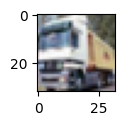

In [3]:
plt.figure(figsize=(1, 2))
dataset = torchvision.datasets.CIFAR10(root="data", download=True)
#print one image from the dataset
image, label = dataset[1]
plt.imshow(image)

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    fig = plt.figure(figsize=(num_cols * scale, num_rows * scale))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(Y[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### Flipping and cropping

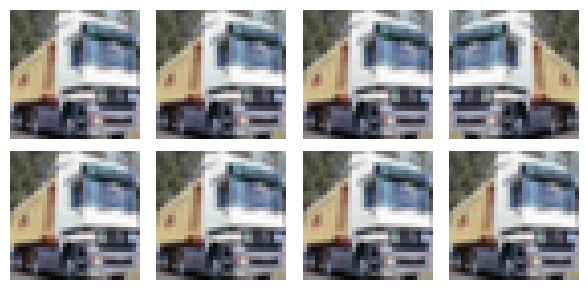

In [5]:
apply(image, torchvision.transforms.RandomHorizontalFlip())

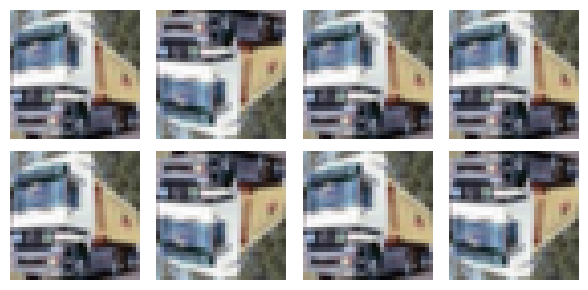

In [6]:
apply(image, torchvision.transforms.RandomVerticalFlip())

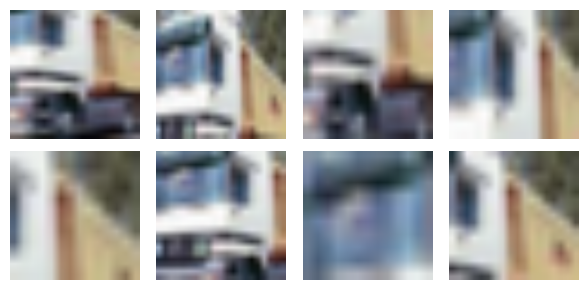

In [7]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(image, shape_aug)

### Changing colors

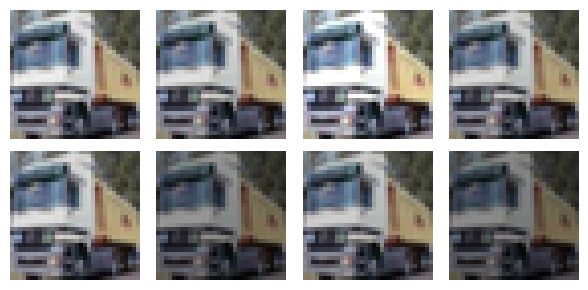

In [8]:
apply(image, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

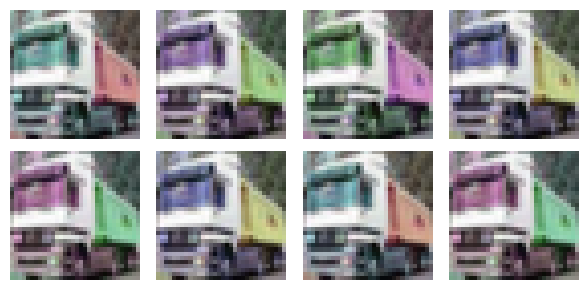

In [9]:
apply(image, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

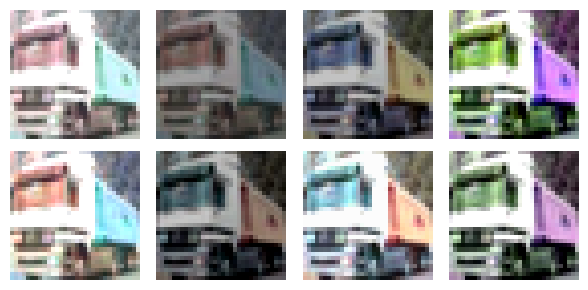

In [10]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(image, color_aug)

### Combining augmentation methods

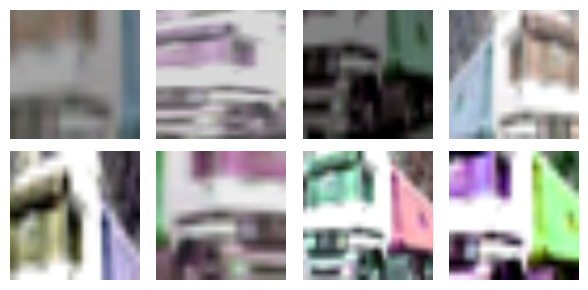

In [11]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(image, augs)

## Training with image augmentation

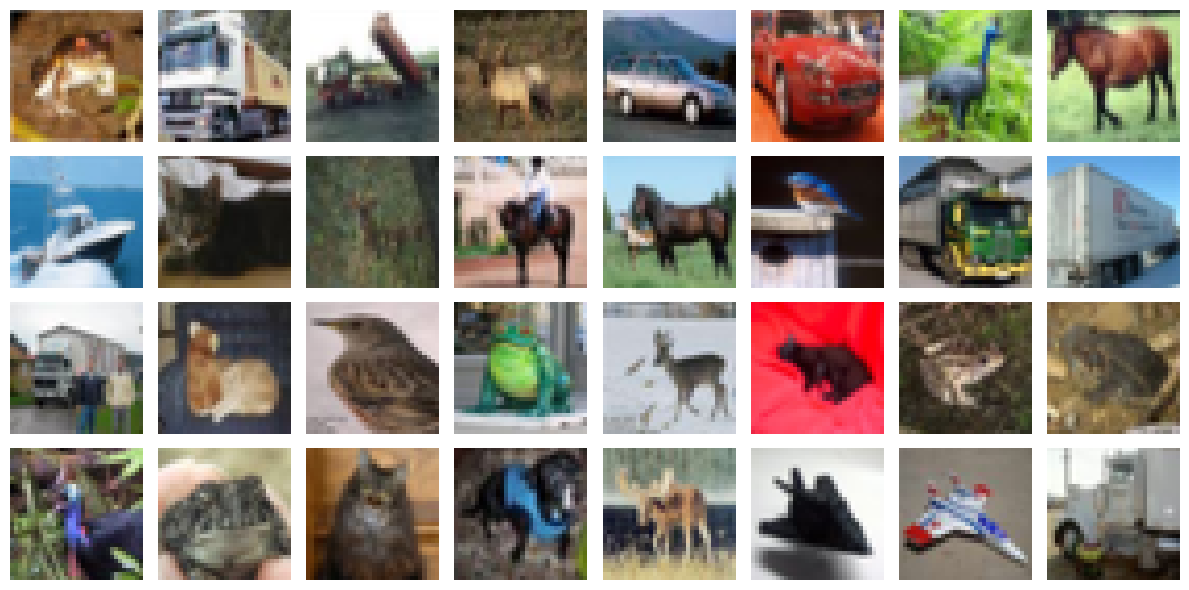

In [12]:
all_images = torchvision.datasets.CIFAR10(train=True, root="data",
                                          download=True)
# Create a figure with the specified size
plt.figure(figsize=(12, 6))
# Display 32 images in a 4x8 grid
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(all_images[i][0])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [14]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=4)
    return dataloader

## Multi-GPU training

In [15]:
class Timer:
    """Recording multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

class Animator:  # Define a new Animator class that properly handles None values
	def __init__(self, xlabel=None, ylabel=None, legend=None):
		self.data = {'train_loss': [], 'train_acc': [], 'test_acc': []}
		self.epochs = []
		
	def add(self, epoch, metrics):
		self.epochs.append(epoch)
		train_loss, train_acc, test_acc = metrics
		if train_loss is not None:
			self.data['train_loss'].append(float(train_loss))
		if train_acc is not None:
			self.data['train_acc'].append(float(train_acc))
		if test_acc is not None:
			self.data['test_acc'].append(float(test_acc))
			
	def show(self):
		plt.figure(figsize=(10, 6))
		for label, values in self.data.items():
			if values:  # Only plot if we have data
				plt.plot(self.epochs[:len(values)], values, label=label)
		plt.xlabel('Epoch')
		plt.ylabel('Metric Value')
		plt.legend()
		plt.grid(True)
		plt.show()

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.to(y.dtype) == y
    return float(cmp.sum())

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

In [16]:

def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices):
    """Train a model with multiple GPUs."""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator()  # Using the custom Animator implementation
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    for epoch in range(num_epochs):
        metric = Accumulator(4)  # Using the custom Accumulator
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                train_loss = metric[0] / metric[2]
                train_acc = metric[1] / metric[3]
                animator.add(epoch + (i + 1) / num_batches, 
                           (train_loss, train_acc, None))
        
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    
    print(f'Loss: {metric[0] / metric[2]:.3f}')
    print(f'Train accuracy: {metric[1] / metric[3]:.3f}')
    print(f'Test accuracy: {test_acc:.3f}')
    print(f'Training speed: {metric[2] * num_epochs / timer.sum():.1f} examples/sec')
    print(f'Device(s) used: {str(devices)}')
    
    animator.show()  # Display the training curves

In [17]:
devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]

def resnet18(num_classes, in_channels=3):
    """Construct a ResNet-18 model."""
    net = torchvision.models.resnet18(weights=None)
    if in_channels != 3:
        net.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    return net

def init_cnn(module):
    """Initialize weights of Conv2D and Linear layers."""
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(module.weight)

In [18]:
batch_size, devices, net = 256, devices, resnet18(10, 3)
net.apply(init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

C:\Users\Ishaan\AppData\Local\Temp\ipykernel_27748\3082397923.py:70: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  self.data = [a + float(b) for a, b in zip(self.data, args)]


Loss: 0.445
Train accuracy: 0.845
Test accuracy: 0.687
Training speed: 12831.1 examples/sec
Device(s) used: [device(type='cuda', index=0)]


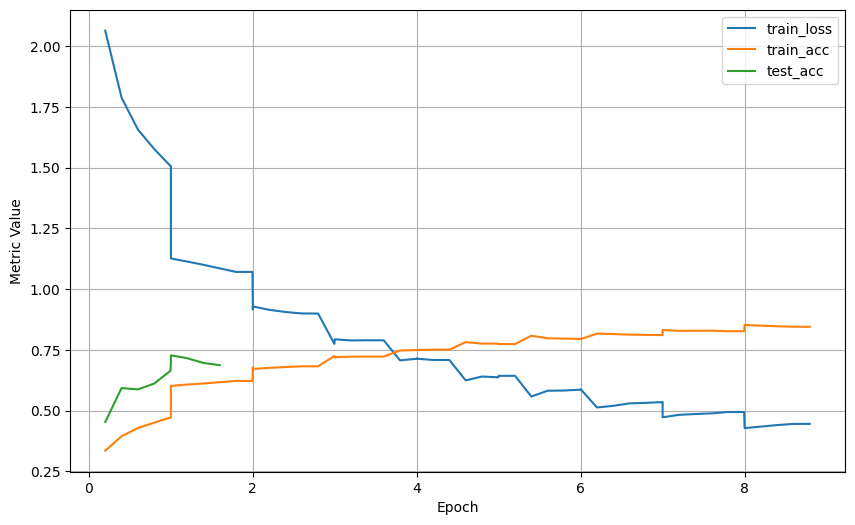

In [19]:
train_with_data_aug(train_augs, test_augs, net)

# Fine-Tuning

## Transfer Learning

In [22]:
dataset_loc = "data/hotdog/hotdog"
train_imgs = torchvision.datasets.ImageFolder(root=dataset_loc + "/train", transform=train_augs)
test_imgs = torchvision.datasets.ImageFolder(root=dataset_loc + "/test", transform=test_augs)

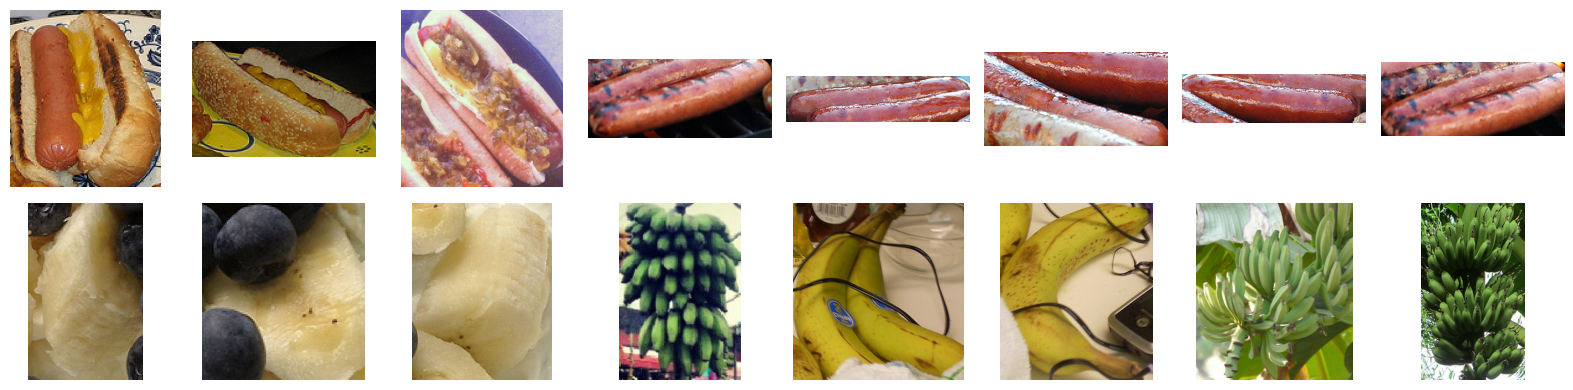

In [24]:
plt.figure(figsize=(16, 4))
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(torchvision.transforms.ToPILImage()(hotdogs[i]))
    plt.axis('off')
    plt.subplot(2, 8, i + 9)
    plt.imshow(torchvision.transforms.ToPILImage()(not_hotdogs[i]))
    plt.axis('off')
plt.tight_layout()

In [25]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

### Defining and initializing the model

In [26]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

c:\Users\Ishaan\Desktop\Personal Projects\Deep-Learning\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ishaan\Desktop\Personal Projects\Deep-Learning\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Ishaan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


In [27]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [28]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0575, -0.0210,  0.0718,  ...,  0.1020, -0.0699, -0.0114],
        [ 0.0674, -0.1019, -0.0397,  ..., -0.0551, -0.0850, -0.0203]],
       requires_grad=True)

### Fine-tuning the model

In [33]:
import os
devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(dataset_loc, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(dataset_loc, 'test'), transform=test_augs),
        batch_size=batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

Loss: 0.169
Train accuracy: 0.946
Test accuracy: 0.929
Training speed: 1073.9 examples/sec
Device(s) used: [device(type='cuda', index=0)]


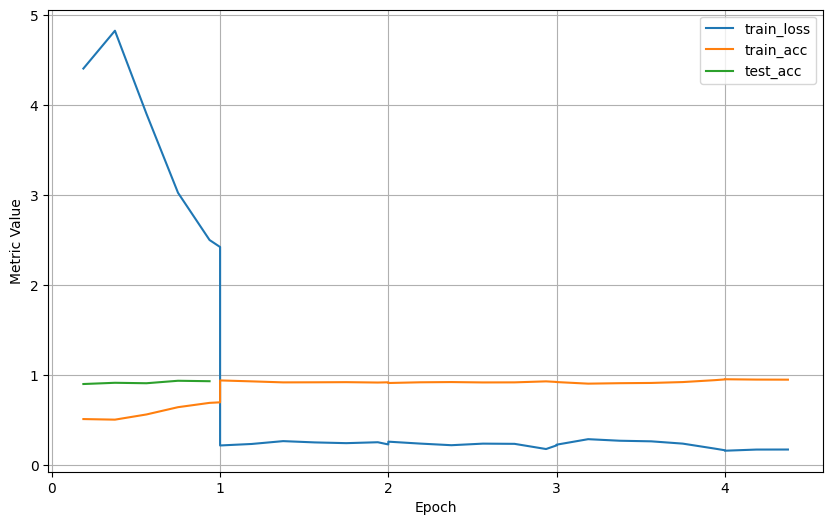

In [34]:
train_fine_tuning(finetune_net, 5e-5)

Loss: 0.385
Train accuracy: 0.837
Test accuracy: 0.834
Training speed: 1071.9 examples/sec
Device(s) used: [device(type='cuda', index=0)]


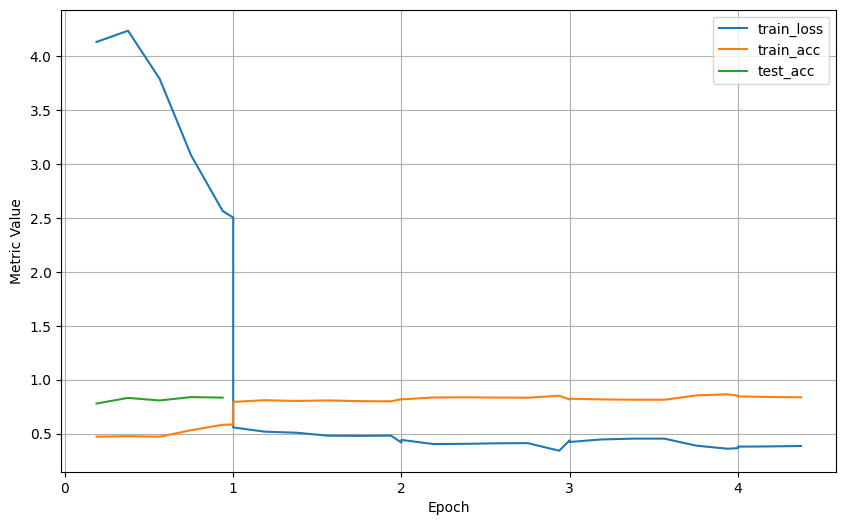

In [35]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

The fine-tuned model seems to perform better for the same epoch because it's inital parameters are more effective